## Goal of this Notebook
In a similar fashion to how we used daily price movements to predict the following day's or weeks price movements, we will use volume to predict the following day's price movement

In [1]:
from stock_utils import *

In [2]:
df = pd.DataFrame()
df = df.from_csv('stock_data/amd.csv')

In [3]:
df.describe()

,close,volume,open,high,low
count,2519.000000,2.519000e+03,2519.000000,2519.000000,2519.000000
mean,5.689273,2.634794e+07,5.697783,5.818195,5.565502
std,3.134940,2.241965e+07,3.140253,3.194429,3.076070
min,1.620000,2.606577e+06,1.620000,1.690000,1.610000
25%,3.220000,1.374866e+07,3.207500,3.302600,3.125000
50%,4.880000,2.026017e+07,4.900000,5.050000,4.740000
75%,7.510000,3.059325e+07,7.535000,7.650000,7.380000
max,15.200000,2.674329e+08,15.450000,15.650000,14.520000


### 1)  Get the daily volume of AMD
We need a way of dealing with the huge variation in volume. Maybe set a baseline, being the avareage of the nearest 50 days. (So for the first day, we have to use the following 49, and the last day, we have to use the previous 49).

In [4]:
def get_volume(df):    
    df = df.sort_index(axis=0) ## We want dates in sequential order
    return df['volume'].as_matrix()

In [16]:
def get_relative_volume(df, relative_period=50):
    df = df.sort_index(axis=0) ## We want dates in sequential order
    absolute_volumes = df['volume'].as_matrix() #.astype(float)
    relative_volumes = np.zeros(len(absolute_volumes))
    
    half = int(relative_period / 2) ## For the middle, branch out this far in either direction
    
    for i in range(len(absolute_volumes)):
        ## Middle
        if i >= relative_period and i < (len(absolute_volumes) - relative_period):
            #print('middle')
            count = 0
            total_volume = 0
            for j in range(half):
                total_volume += absolute_volumes[i-j]
                count += 1
            for j in range(half):
                total_volume += absolute_volumes[i+j+1]
                count += 1
            avg_volume = total_volume / count
            relative_volumes[i] = absolute_volumes[i] / avg_volume
        ## Beginning
        elif i < relative_period:
            #print('beginning')
            count = 0
            total_volume = 0
            for j in range(relative_period):
                total_volume += absolute_volumes[i+j]
                count += 1
            avg_volume = total_volume / count
            relative_volumes[i] = absolute_volumes[i] / avg_volume
        ## End
        elif i >= (len(absolute_volumes) - relative_period):
            #print('end')
            count = 0
            total_volume = 0
            for j in range(relative_period):
                total_volume += absolute_volumes[i-j]
                count += 1
            avg_volume = total_volume / count
            relative_volumes[i] = absolute_volumes[i] / avg_volume
        else:
            print('something went wrong')
    #for i in range((len(absolute_volumes)) - (len(absolute_volumes) - relative_period)):
        #print(i)
        
    return relative_volumes

In [6]:
relative_period = 50
relative_volumes = get_relative_volume(df, relative_period=relative_period)

[ 12583200.  14462540.  14791800.  24718800.  30283050.  27642900.
  29007470.  18663500.  12501300.  13256500.]


### 2) Plot Volumes -- absolute and relative

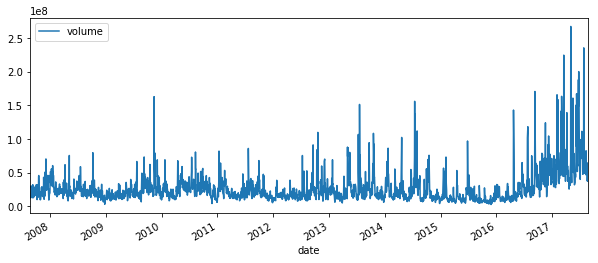

In [7]:
plt.figure(figsize=(10, 4))
df['volume'].plot(label='volume')
plt.legend()
plt.show()

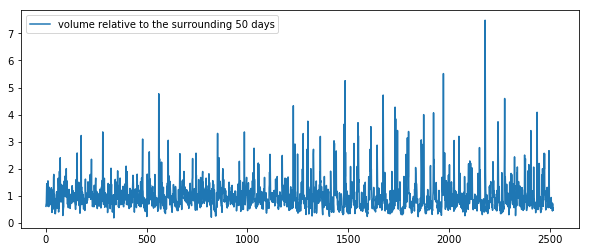

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(relative_volumes, label='volume relative to the surrounding ' + str(relative_period) + ' days')
plt.legend()
plt.show()

### 3) Plot the kernel density estimate of volume for this stock
(Using the scipy default which is Scott's Rule) More info [here](https://en.wikipedia.org/wiki/Kernel_density_estimation)

In [9]:
def plot_gaussian(x, x_min=-10, x_max=10, n=10000, fill=False, label=''):
    """ 
    Expects an np array of movement percentages, 
    plots the gaussian kernel density estimate
    """
    #x_min, x_max = min(x), max(x)
    
    ## Learn the kernel-density estimate from the data
    density = stats.gaussian_kde(x)
    
    ## Evaluate the output on some data points
    xs = np.linspace(x_min, x_max, n)
    y = density.evaluate(xs)
    
    ## Create the plot
    plt.plot(xs, y, label=label)
    plt.xlabel('Daily Intra-Day Range')
    plt.ylabel('Density')
    
    if (fill):
        plt.fill_between(xs, 0, y)

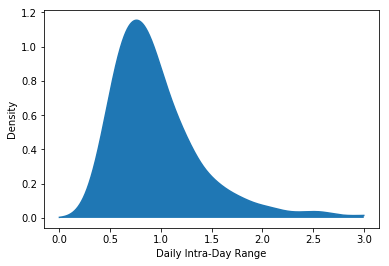

In [10]:
## Plot the output
plot_gaussian(relative_volumes, x_min=0, x_max=3, fill=True)
plt.show()

In [11]:
print('The average relative volume was ' + '{0:.2f}'.format(np.mean(relative_volumes)) ) 
print('The standard deviation is ' + '{0:.2f}'.format(np.std(relative_volumes)) ) 

The average relative volume was 0.99
The standard deviation is 0.56


## Plot the relative volumes of a few stocks

In [12]:
g = glob.glob('stock_data/*.csv')

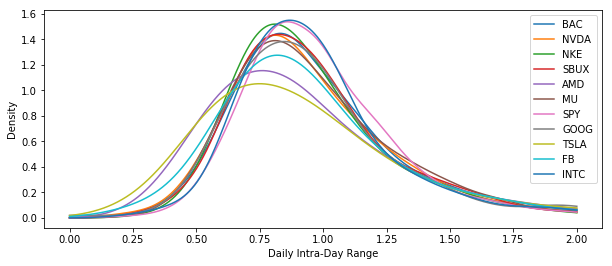

In [18]:
plt.figure(figsize=(10, 4))
for i in range(len(g)):
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    ticker = ticker_from_csv(g[i])
    
    relative_volumes = get_relative_volume(df, relative_period=50)
    plot_gaussian(relative_volumes, x_min=0, x_max=2, label=ticker)

plt.legend()
plt.show()

## Visualizing IVolume Categories
#### We would like to differentiate between the following price movement categories:

1. **Very Small**  
movement < mu - σ
2. **Small**  
movement < mu
3. **Large**  
movement > mu
4. **Very Large**  
movement > mu + σ


These categories are defined arbitrarily and can be changed if something more suitable or sensible is found.

In [19]:
def plot_gaussian_categorical(x, x_min=-10, x_max=10, n=10000, title=''):
    """
    Expects an np array of movement percentages, 
    plots the gaussian kernel density estimate
    """
    ## Learn the kernel-density estimate from the data
    density = stats.gaussian_kde(x)
    
    ## Evaluate the output on some data points
    xs = np.linspace(x_min, x_max, n)
    y = density.evaluate(xs)
    
    ## Create the plot
    plt.plot(xs, y)
    plt.xlabel('Daily Intra-Day Percentage')
    plt.ylabel('Density')
    
    ## Get stats
    mu, sigma = np.mean(x), np.std(x)
 
    ## Plot with conditionals
    plt.fill_between(xs, 0, y, where= xs < mu, facecolor='yellow', interpolate=True) ## Small
    plt.fill_between(xs, 0, y, where= xs < (mu - sigma), facecolor='orange', interpolate=True) ## Very Small
    
    plt.fill_between(xs, 0, y, where= xs > mu, facecolor='green', interpolate=True) ## Large
    plt.fill_between(xs, 0, y, where= xs > (mu + sigma), facecolor='blue', interpolate=True) ## Very Large
    
    ## Label mu and sigma
    plt.text(x_min + 1, max(y) * 0.8, r'$\mu$ = ' + '{0:.2f}'.format(mu))
    plt.text(x_min + 1, max(y) * 0.9, r'$\sigma$ = ' + '{0:.2f}'.format(sigma))
    ## Set title if given
    if (len(title) != 0):
        plt.title(title)

In [20]:
df = df.from_csv('stock_data/amd.csv')
relative_volumes = get_relative_volume(df, relative_period=50)

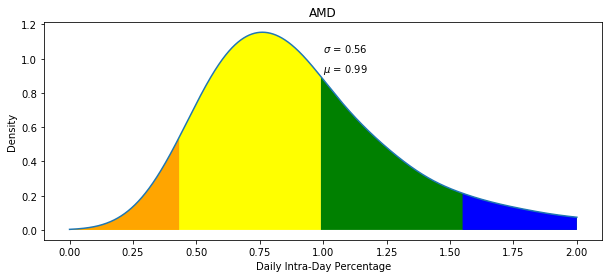

In [22]:
plt.figure(figsize=(10,4))
plot_gaussian_categorical(relative_volumes, title='AMD', x_min=0, x_max=2)
plt.show()

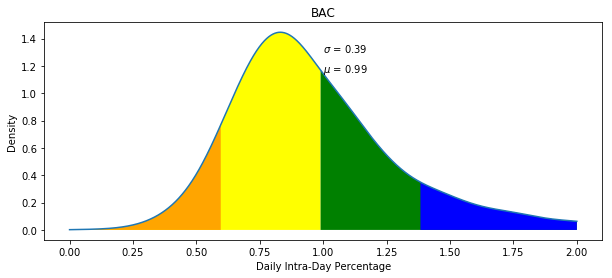

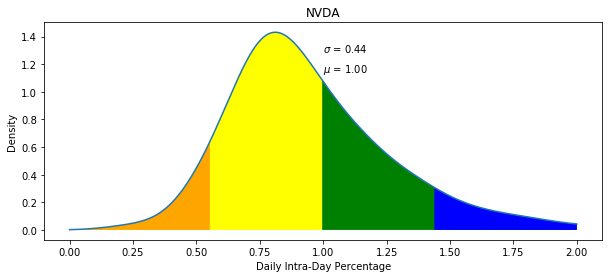

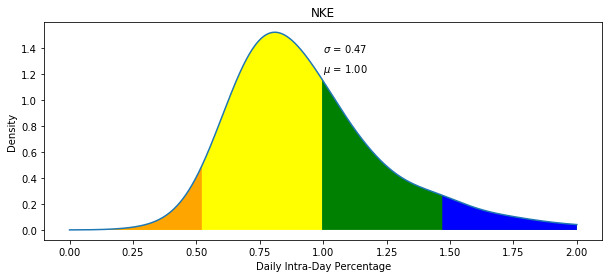

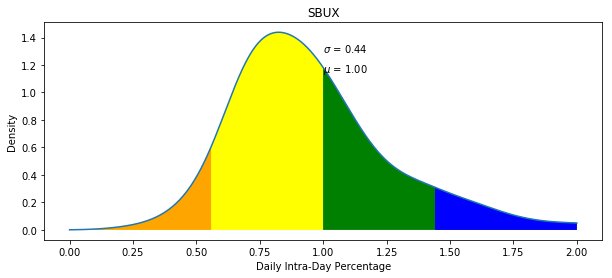

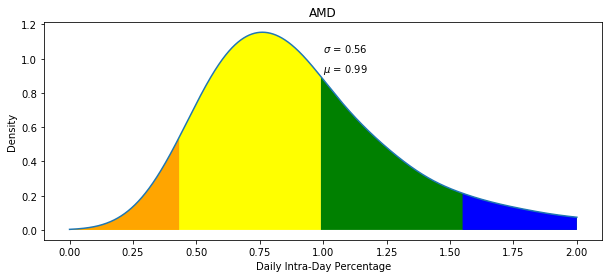

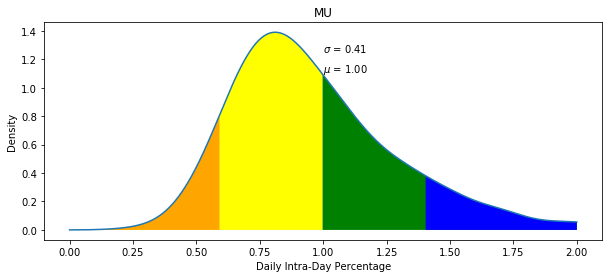

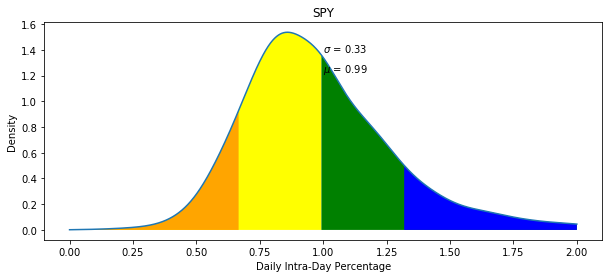

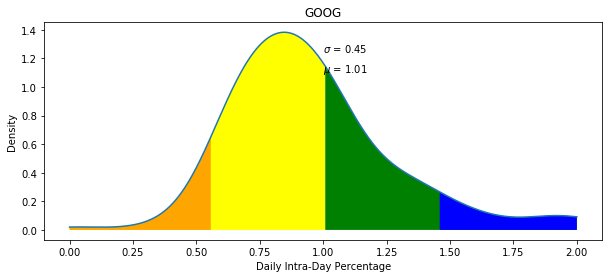

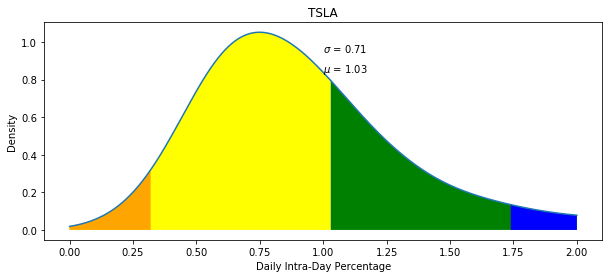

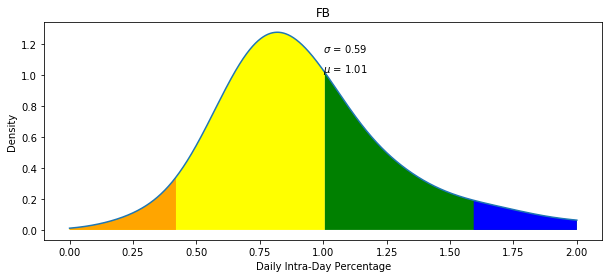

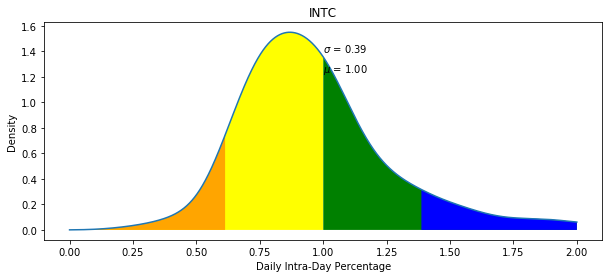

In [23]:
## Let's try with the rest
g = glob.glob('stock_data/*.csv')

for i in range(len(g)):
    plt.figure(figsize=(10,4))
    df = pd.DataFrame()
    df = df.from_csv(g[i])
    relative_volumes = get_relative_volume(df, relative_period=50)
    plot_gaussian_categorical(relative_volumes, title=ticker_from_csv(g[i]), x_min=0, x_max=2)

plt.show()

# Predicting price movements of the next day given previous day's volume
I would guess that volume is a good proxy measure for volatilty, and therefore price movements will be more extreme the day after higher volume.

In [24]:
from stock_utils import *

In [49]:
def categorize_volumes(ranges):
    """Given an array of ranges, return an array of categories based on how relatively large the ranges are"""
    mu, sigma = np.mean(ranges), np.std(ranges)
    categories = []
    
    for i in range(len(ranges)):
        if (ranges[i] <= (mu - sigma)):
            categories.append('vl')  ## very low
        elif (ranges[i] < mu):
            categories.append('l')   ## low
        elif (ranges[i] >= (mu + sigma)):
            categories.append('h')   ## high
        elif (ranges[i] >= mu):
            categories.append('vh')  ## very high
        else:
            print("didn't fit")
    
    return categories

In [55]:
def count_volume_category(categories, cat_to_count):
    count = 0
    for i in range(len(categories)):
        if categories[i] == cat_to_count:
            count = count + 1
    return count

In [34]:
def count_trends(trends, trend_to_count):
    count = 0
    for i in range(len(trends)):
        if trends[i] == trend_to_count:
            count = count + 1
    return count

In [71]:
def get_two_day_volume_trends(vol_categories, movement_categories):
    two_day_trends = []
    for i in range(len(vol_categories) - 1):
        two_day_trends.append(vol_categories[i] + '_' + movement_categories[i+1])
    return two_day_trends

In [67]:
df = pd.DataFrame()
df = df.from_csv('stock_data/nvda.csv')
## From now on, we will use percentage since it is normalzed across stock prices
daily_rel_volumes = get_relative_volume(df, relative_period=50)
daily_movements = get_price_movements(df)

In [68]:
rel_volume_categories = categorize_volumes(daily_rel_volumes)
movement_categories = categorize_movements(daily_movements, n_cats=4)

In [72]:
two_day_vol_trends = get_two_day_volume_trends(rel_volume_categories, movement_categories)

In [77]:
vl_count = count_volume_category(rel_volume_categories, 'vl')
l_count = count_volume_category(rel_volume_categories, 'l')
h_count = count_volume_category(rel_volume_categories, 'h')
vh_count = count_volume_category(rel_volume_categories, 'vh')

total_count = vl_count + l_count + h_count + vh_count

vl_prob = vl_count / total_count
l_prob = l_count / total_count
h_prob = h_count / total_count
vh_prob = vh_count / total_count

vol_cat_probs = [vl_prob, l_prob, h_prob, vh_prob]

print('Number of very small range days: ' + str(vl_count))
print('Number of small range days: ' + str(l_count))
print('Number of large range days: ' + str(h_count))
print('Number of very large range days: ' + str(vh_count))

Number of very small range days: 156
Number of small range days: 1414
Number of large range days: 258
Number of very large range days: 691


In [78]:
## Movements
bd_count = count_movement_category(movement_categories, 'bd')
sd_count = count_movement_category(movement_categories, 'sd')
sg_count = count_movement_category(movement_categories, 'sg')
bg_count = count_movement_category(movement_categories, 'bg')

total_cat_count = len(movement_categories)

p_bd = bd_count / total_cat_count
p_sd = sd_count / total_cat_count
p_sg = sg_count / total_cat_count
p_bg = bg_count / total_cat_count

movement_cat_probs = [p_bd, p_sd, p_sg, p_bg]

### Visuals

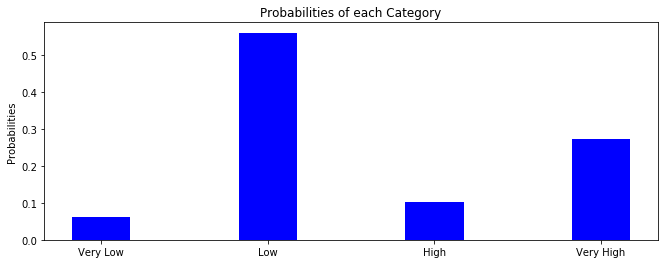

In [79]:
## Relative Volume: category probabilities

plt.figure(figsize=(11,4))
vol_category_names = ('Very Low', 'Low', 'High', 'Very High')
ind = np.arange(4)
width = 0.35
p1 = plt.bar(ind, vol_cat_probs, width, color='b', align='center')
plt.ylabel('Probabilities')
plt.title('Probabilities of each Category')
plt.xticks(ind, vol_category_names)

plt.show()

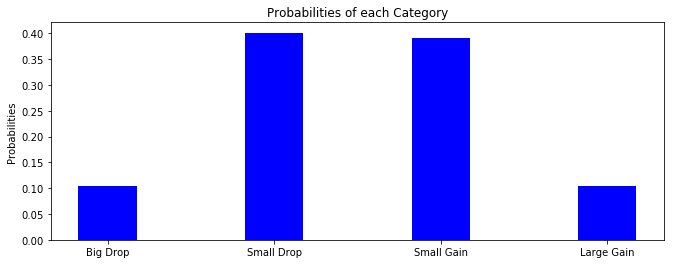

In [80]:
## Daily price movement: category probabilities

plt.figure(figsize=(11,4))
movement_category_names = ('Big Drop', 'Small Drop', 'Small Gain', 'Large Gain')
ind = np.arange(4)
width = 0.35
p1 = plt.bar(ind, movement_cat_probs, width, color='b', align='center')
plt.ylabel('Probabilities')
plt.title('Probabilities of each Category')
plt.xticks(ind, movement_category_names)

plt.show()

In [84]:
def plot_probability_bar_graph_volumes(name, count, two_day_trends, show_baseline=True, n_cats=4):
    if (n_cats != 4):
        raise ValueError('Only four categories are supported at this time')
        
    two_day_probs = []
    volume_full_names = {'vl':'very low', 'l':'low', 'h':'high', 'vh':'very high'}
    
    all_categories = ['bd', 'sd', 'sg', 'bg']
    for next_day in all_categories:
        two_day_name = name +'_' + next_day
        two_day_count = count_trends(two_day_trends, two_day_name)
        two_day_prob = two_day_count / count
        two_day_probs.append(two_day_prob)

    plt.figure(figsize=(11,4))
    movement_category_names = ('Big Drop', 'Small Drop', 'Small Gain', 'Big Gain')
    volume_category_names = ('Very Low', 'Low', 'High', 'Very High')
    ind = np.arange(4)
    width = 0.25
    if (show_baseline):
        orig_pl = plt.bar(ind+width, movement_cat_probs, width, color='b', label='Original')
    conditioned_pl = plt.bar(ind, two_day_probs, width, color='r', label='After a ' + volume_full_names[name] + ' volume day')
    plt.ylabel('Probabilities')
    plt.title('Probabilities of each Category')
    plt.xticks(ind+width, movement_category_names)
    plt.legend()
    plt.show()

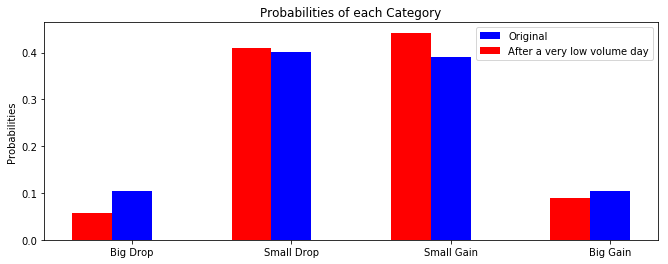

In [87]:
plot_probability_bar_graph_volumes('vl', vl_count, two_day_vol_trends)

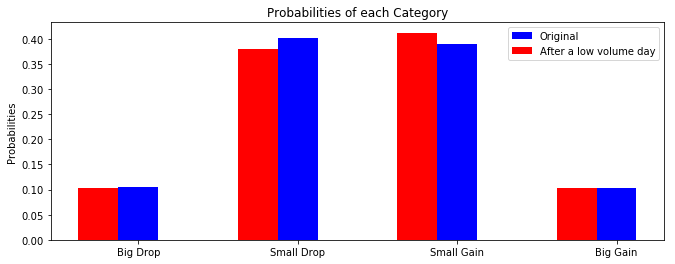

In [88]:
plot_probability_bar_graph_volumes('l', l_count, two_day_vol_trends)

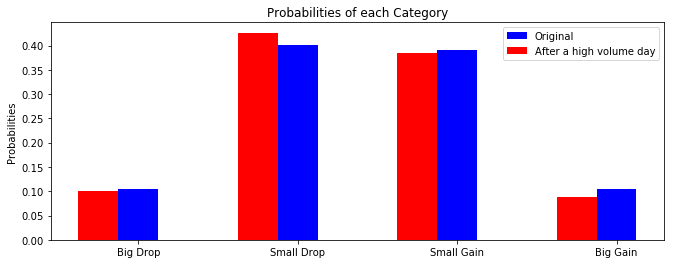

In [89]:
plot_probability_bar_graph_volumes('h', h_count, two_day_vol_trends)

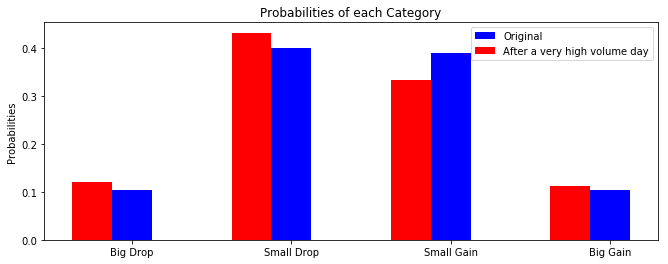

In [90]:
plot_probability_bar_graph_volumes('vh', vh_count, two_day_vol_trends)

Interesting... After relatively low volume days, small gains are more liklely, whears after relatively high volume days, volatility goes up, but just barely. Also, small losses are more likely after high volume days for NVDA.

# All stocks

In [99]:
def get_volume_trends_all_stocks(period_length, all_category_names, trend_length=2, n_cats=4):
	"""
	Get an aggregate of trends for all stocks, from a specified period_length (1 would be daily, 7 weekly, etc.),
	a specified trend_length(2 would be looking for two day trends), and a list all_category_names that contains
	each possible category name.
	
	We return: 
	  all_trends          -- The aggregate list of all trends accross stocks
	  all_category_counts -- The aggregate count of each category accross stocks
	  all_category_probs  -- The probability of each category accross stocks
	"""
	if (trend_length != 2):
		raise ValueError('Trend length must be two for now')
	if (n_cats != 4):
		raise ValueError('Number of categories musr be four for now')
    
	g = glob.glob('stock_data/*.csv')
	
	all_volume_categories = []
	all_trends = []
	
	all_volume_category_counts = np.zeros(len(all_category_names), dtype=np.int)
	total_count = 0
	
	for i in range(len(g)):
		df = pd.DataFrame()
		df = df.from_csv(g[i])
		
		movements = get_price_movements(df, period=period_length)
		movement_categories = categorize_movements(movements, n_cats=n_cats)
		
		volume_categories = categorize_volumes(get_relative_volume(df, relative_period=50))
		#
		#all_movements.extend(movements)
		all_volume_categories.extend(movement_categories)
		
		for j in range(len(all_category_names)):
			#print(all_category_names[j])
			all_volume_category_counts[j] += count_volume_category(volume_categories, all_category_names[j])
		#print(all_range_category_counts)
		trends = get_two_day_volume_trends(volume_categories, movement_categories)
		all_trends.extend(trends)
	
	all_category_probs = np.zeros(len(all_category_names), dtype=np.float)
	total_count = len(all_volume_categories)
	for i in range(len(all_category_names)):
		all_category_probs[i] = (all_volume_category_counts[i] / total_count)

	return (all_trends, all_volume_category_counts, all_category_probs, all_volume_categories)

In [100]:
(all_two_day_trends, all_volume_category_counts, _, _) = get_volume_trends_all_stocks(1, ['vl', 'l', 'h', 'vh'])

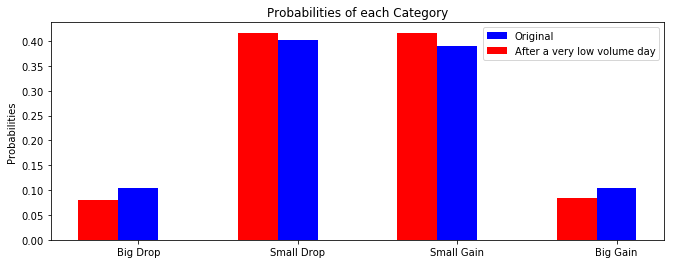

In [101]:
plot_probability_bar_graph_volumes('vl', all_volume_category_counts[0], all_two_day_trends)

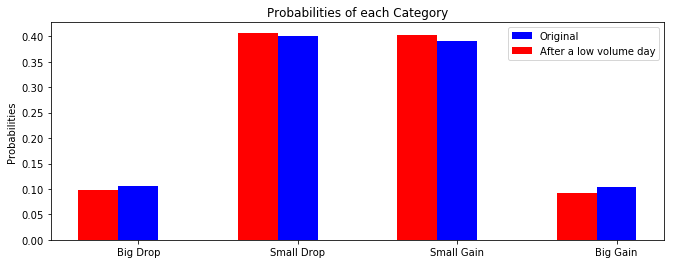

In [102]:
plot_probability_bar_graph_volumes('l', all_volume_category_counts[1], all_two_day_trends)

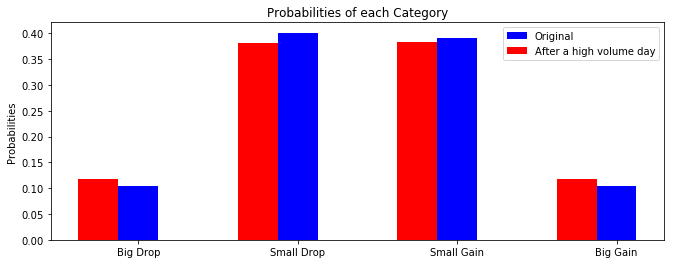

In [103]:
plot_probability_bar_graph_volumes('h', all_volume_category_counts[2], all_two_day_trends)

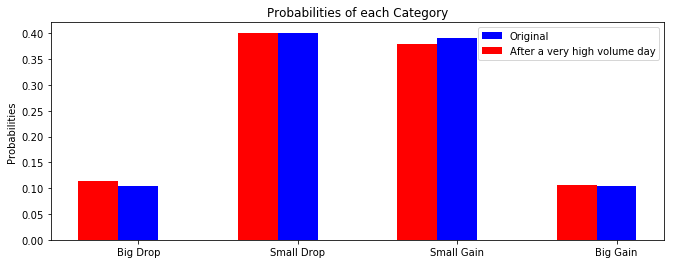

In [104]:
plot_probability_bar_graph_volumes('vh', all_volume_category_counts[3], all_two_day_trends)

It seems that when average over all stocks, volume is just a weak predictor of volatility